In [ ]:
import pandas as pd
import statsmodels.api as sm
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import hsv
from shapely.geometry import Point, LineString
import pybrms
canvasWidth = 1000  

In [ ]:
def process_file(filename):
    participant_ID = os.path.splitext(os.path.basename(filename))[0]
    
    # Load the data
    df = pd.read_csv(filename)
    
    # Add the participant ID
    df['participant_ID'] = participant_ID
    
    # Select columns
    columns = ['subject_id','study_id','session_id','participant_ID', 'trial_index','trial_name', 'flipped', 'ball_X', 'triangle_final_x', 
               'triangle_final_y', 'response_time' , 'obstacle_groundTruth_x', 
               'obstacle_groundTruth_y', 'currentTrial','stimulus_idx', 'obstacle_idx',
               'obstacle_initial_x', 'obstacle_initial_y','runnerFPS']
    df = df[columns]
    
    # Select rows
    df = df[df['trial_name'].isin(['fallScene', 'reconstruct'])]
    if df.shape[0] != 144: 
        print(f"For {participant_ID}, total rows: {df.shape[0]}")
    if df['stimulus_idx'].nunique() != 12 or df['obstacle_idx'].nunique() != 6:
        print(f'ERROR IN DATA: {participant_ID}')
        print(f"Unique stimulus_idx: {df['stimulus_idx'].nunique()}, unique obstacle_idx: {df['obstacle_idx'].nunique()}")
    
    # Merge 'fallScene' with 'reconstruct'
    mergedDf = df.groupby(['participant_ID', 'currentTrial'], as_index=False).first() # take the first non-null value
    
    # Check and perform flip operation
    mergedDf.loc[mergedDf['flipped'] == True, 'ball_X_final'] = canvasWidth - mergedDf['ball_X']
    mergedDf.loc[mergedDf['flipped'] == True, 'obstacle_groundTruth_x_final'] = canvasWidth - mergedDf['obstacle_groundTruth_x']
    mergedDf.loc[mergedDf['flipped'] == True, 'obstacle_initial_x_final'] = canvasWidth - mergedDf['obstacle_initial_x']

    # Create new columns for non-flipped
    mergedDf.loc[mergedDf['flipped'] == False, 'ball_X_final'] = mergedDf['ball_X']
    mergedDf.loc[mergedDf['flipped'] == False, 'obstacle_groundTruth_x_final'] = mergedDf['obstacle_groundTruth_x']
    mergedDf.loc[mergedDf['flipped'] == False, 'obstacle_initial_x_final'] = mergedDf['obstacle_initial_x']
    
    return mergedDf

In [3]:
# def conductRegress(df):
#     # Prepare the data
#     X_x = df[['obstacle_groundTruth_x_final', 'obstacle_initial_x_final']]
#     X_y = df[['obstacle_groundTruth_y', 'obstacle_initial_y']]
#     X_x = sm.add_constant(X_x)  # adding a constant (intercept term)
#     X_y = sm.add_constant(X_y)

#     y_x = df['triangle_final_x']
#     y_y = df['triangle_final_y']

#    # Fit the model for x
#     model_x = sm.OLS(y_x, X_x).fit()
#     params_x = model_x.params
#     std_err_x = model_x.bse
#     p_values_x = model_x.pvalues
#     adj_r2_x = model_x.rsquared_adj
#     x_results = {'coef': params_x, 'std_err': std_err_x, 'p_values':p_values_x, 'adj_R2': adj_r2_x}
#     if params_x['obstacle_groundTruth_x_final'] <= 0.6:
#         print('Invalid Response')
#         print(f"obstacle_groundTruth_x_final coef: {params_x['obstacle_groundTruth_x_final']}")
#         print(f"obstacle_initial_x coef: {params_x['obstacle_initial_x_final']}")
#         print(f"obstacle_initial_x p-value: {p_values_x['obstacle_initial_x_final']}")

#     # Fit the model for y
#     model_y = sm.OLS(y_y, X_y).fit()
#     params_y = model_y.params
#     std_err_y = model_y.bse
#     p_values_y = model_y.pvalues
#     adj_r2_y = model_y.rsquared_adj
#     y_results = {'coef': params_y, 'std_err': std_err_y, 'p_values':p_values_y, 'adj_R2': adj_r2_y}

#     return x_results, y_results


### if using a linear mixed effects model
def conductRegress(df): 
    # Model for x
    # only random intercepts are being modeled for 'subject_id'
    model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final + obstacle_initial_x_final", df, groups=df['subject_id']).fit()
#     model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final", df, groups=df['subject_id']).fit()
    x_results = {
        'coef': model_x.params, 
        'std_err': model_x.bse, 
        'p_values': model_x.pvalues, 
        'log_likelihood': model_x.llf
    }
    print(model_x.summary())

    # Check for specific coefficient values
    if x_results['coef']['obstacle_groundTruth_x_final'] <= 0.6:
        print('Invalid Response')
        print(f"obstacle_groundTruth_x_final coef: {x_results['coef']['obstacle_groundTruth_x_final']}")
        print(f"obstacle_initial_x coef: {x_results['coef']['obstacle_initial_x_final']}")
        print(f"obstacle_initial_x p-value: {x_results['p_values']['obstacle_initial_x_final']}")
    
    # Model for y
    model_y = smf.mixedlm("triangle_final_y ~ obstacle_groundTruth_y + obstacle_initial_y", df, groups=df['subject_id']).fit()
    y_results = {
        'coef': model_y.params, 
        'std_err': model_y.bse, 
        'p_values': model_y.pvalues, 
        'log_likelihood': model_y.llf
    }

    return x_results, y_results

In [4]:
directory = 'data_pilot_v1.0/'
# directory = 'data_pilot_v0/'
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
print(f'Number of participants: {len(files)}.')

# Process each file
dfs = []
X_coor_results = {}
Y_coor_results = {}
for file in files:
    df = process_file(directory + file)
    
    # conduct regession for individual participants
    x_results, y_results = conductRegress(df)
    X_coor_results[file] = x_results
    Y_coor_results[file] = y_results
    dfs.append(df)

# Merge all dataframes
df_all = pd.concat(dfs, ignore_index=True)

## flip rate
flipRate = df_all['flipped'].mean()
print(f'Flip Rate: {flipRate}')

# Save the cleaned data to a new CSV file
# df_all.to_csv('data_all/cleaned_file_pilot_v1.csv', index=False)

Number of participants: 20.
                    Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      triangle_final_x
No. Observations:       72           Method:                  REML            
No. Groups:             1            Scale:                   282.7559        
Min. group size:        72           Log-Likelihood:          -308.4946       
Max. group size:        72           Converged:               Yes             
Mean group size:        72.0                                                  
------------------------------------------------------------------------------
                              Coef.     Std.Err.     z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                      5.620        21.356  0.263 0.792 -36.237 47.477
obstacle_groundTruth_x_final   0.983         0.016 61.406 0.000   0.952  1.014
obstacle_initial_x_final       0.013         

                     Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       triangle_final_x
No. Observations:       72            Method:                   REML            
No. Groups:             1             Scale:                    1113.9354       
Min. group size:        72            Log-Likelihood:           -355.7918       
Max. group size:        72            Converged:                Yes             
Mean group size:        72.0                                                    
--------------------------------------------------------------------------------
                              Coef.      Std.Err.      z    P>|z| [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      80.293         41.672  1.927 0.054 -1.384 161.969
obstacle_groundTruth_x_final    0.986          0.032 30.741 0.000  0.923   1.048
obstacle_initial_x_final       -0.091          0.0

In [ ]:
df_all

In [ ]:
print(conductRegress(df_all))

In [ ]:
# Define the regression formula
formula = "triangle_final_x ~ obstacle_groundTruth_x_final"

# Fit the GLS model
gls_model_0 = smf.gls(formula, data=df_all).fit()
print(gls_model_0.summary())

In [ ]:
# Define the regression formula
formula = "triangle_final_x ~ obstacle_groundTruth_x_final + obstacle_initial_x_final"

# Fit the GLS model
gls_model = smf.gls(formula, data=df_all).fit()
print(gls_model.summary())

In [ ]:
# Define the regression formula
formula = "triangle_final_y ~ obstacle_groundTruth_y + obstacle_initial_y"

# Fit the GLS model
gls_model_y = smf.gls(formula, data=df_all).fit()
print(gls_model_y.summary())

In [ ]:
# Fit the OLS model
ols_model = smf.ols(formula, data=df_all).fit()

# Print the summary of the model
print(ols_model.summary())

## Functions to plot trajectory

In [34]:
def preprocessTrajectoryData(filename):
    df = pd.read_csv(filename)
    columns = ['trial_index', 'trail', 'flipped', 'stimulus_idx', 'currentTrial']
    df = df[columns]
    cleaned_df = df.groupby(['trial_index'], as_index=False).first()
    return cleaned_df
    
def drawTrajectory(condition, df, ax, zorder, colorIsSpeed = True):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset['trail']
    for i in range(len(trails)):
        data_string = subset['trail'].iloc[i]
        flip = subset['flipped'].iloc[i]
        data_list = json.loads(data_string)
        x_coords = [(canvasWidth - item['position']['x']) if flip else item['position']['x'] for item in data_list]
        y_coords = [item['position']['y'] for item in data_list]
        speeds = [item['speed'] for item in data_list]
        if colorIsSpeed:
            ax.scatter(x_coords, y_coords, c=speeds, cmap='hsv', s=4, vmin=global_min, vmax=global_max, zorder = zorder)
        else:
            ax.scatter(x_coords, y_coords, c='cyan', s=4, zorder = zorder)
            
def drawSimulatedTrajectory(condition, trajectoryName, df, ax, zorder):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset[trajectoryName]
    data_list = subset[trajectoryName].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.scatter(x_coords, y_coords, c='darkblue', s=4, zorder = zorder)
    
df_simulated = pd.read_json('../Model Fitting/runSimulation/simulated12_trial_data_human_centroid.json')

In [6]:
filename = 'getTrajectory/trajectory_withoutFlip_72_200fps.csv'
trajectory_df = preprocessTrajectoryData(filename)
global_min = trajectory_df.loc[1:]['trail'].apply(lambda x: min([item['speed'] for item in json.loads(x)])).min()
global_max = trajectory_df.loc[1:]['trail'].apply(lambda x: max([item['speed'] for item in json.loads(x)])).max()

## Contour Plot

In [7]:
#### add a column called triangle_final_x_flipBack
df_all['triangle_final_x_flipback'] = np.where(df_all['flipped'] == True, 
                                    canvasWidth - df_all['triangle_final_x'], 
                                    df_all['triangle_final_x'])

### Contour Plot without marginal distribution (not grouped by anchor)

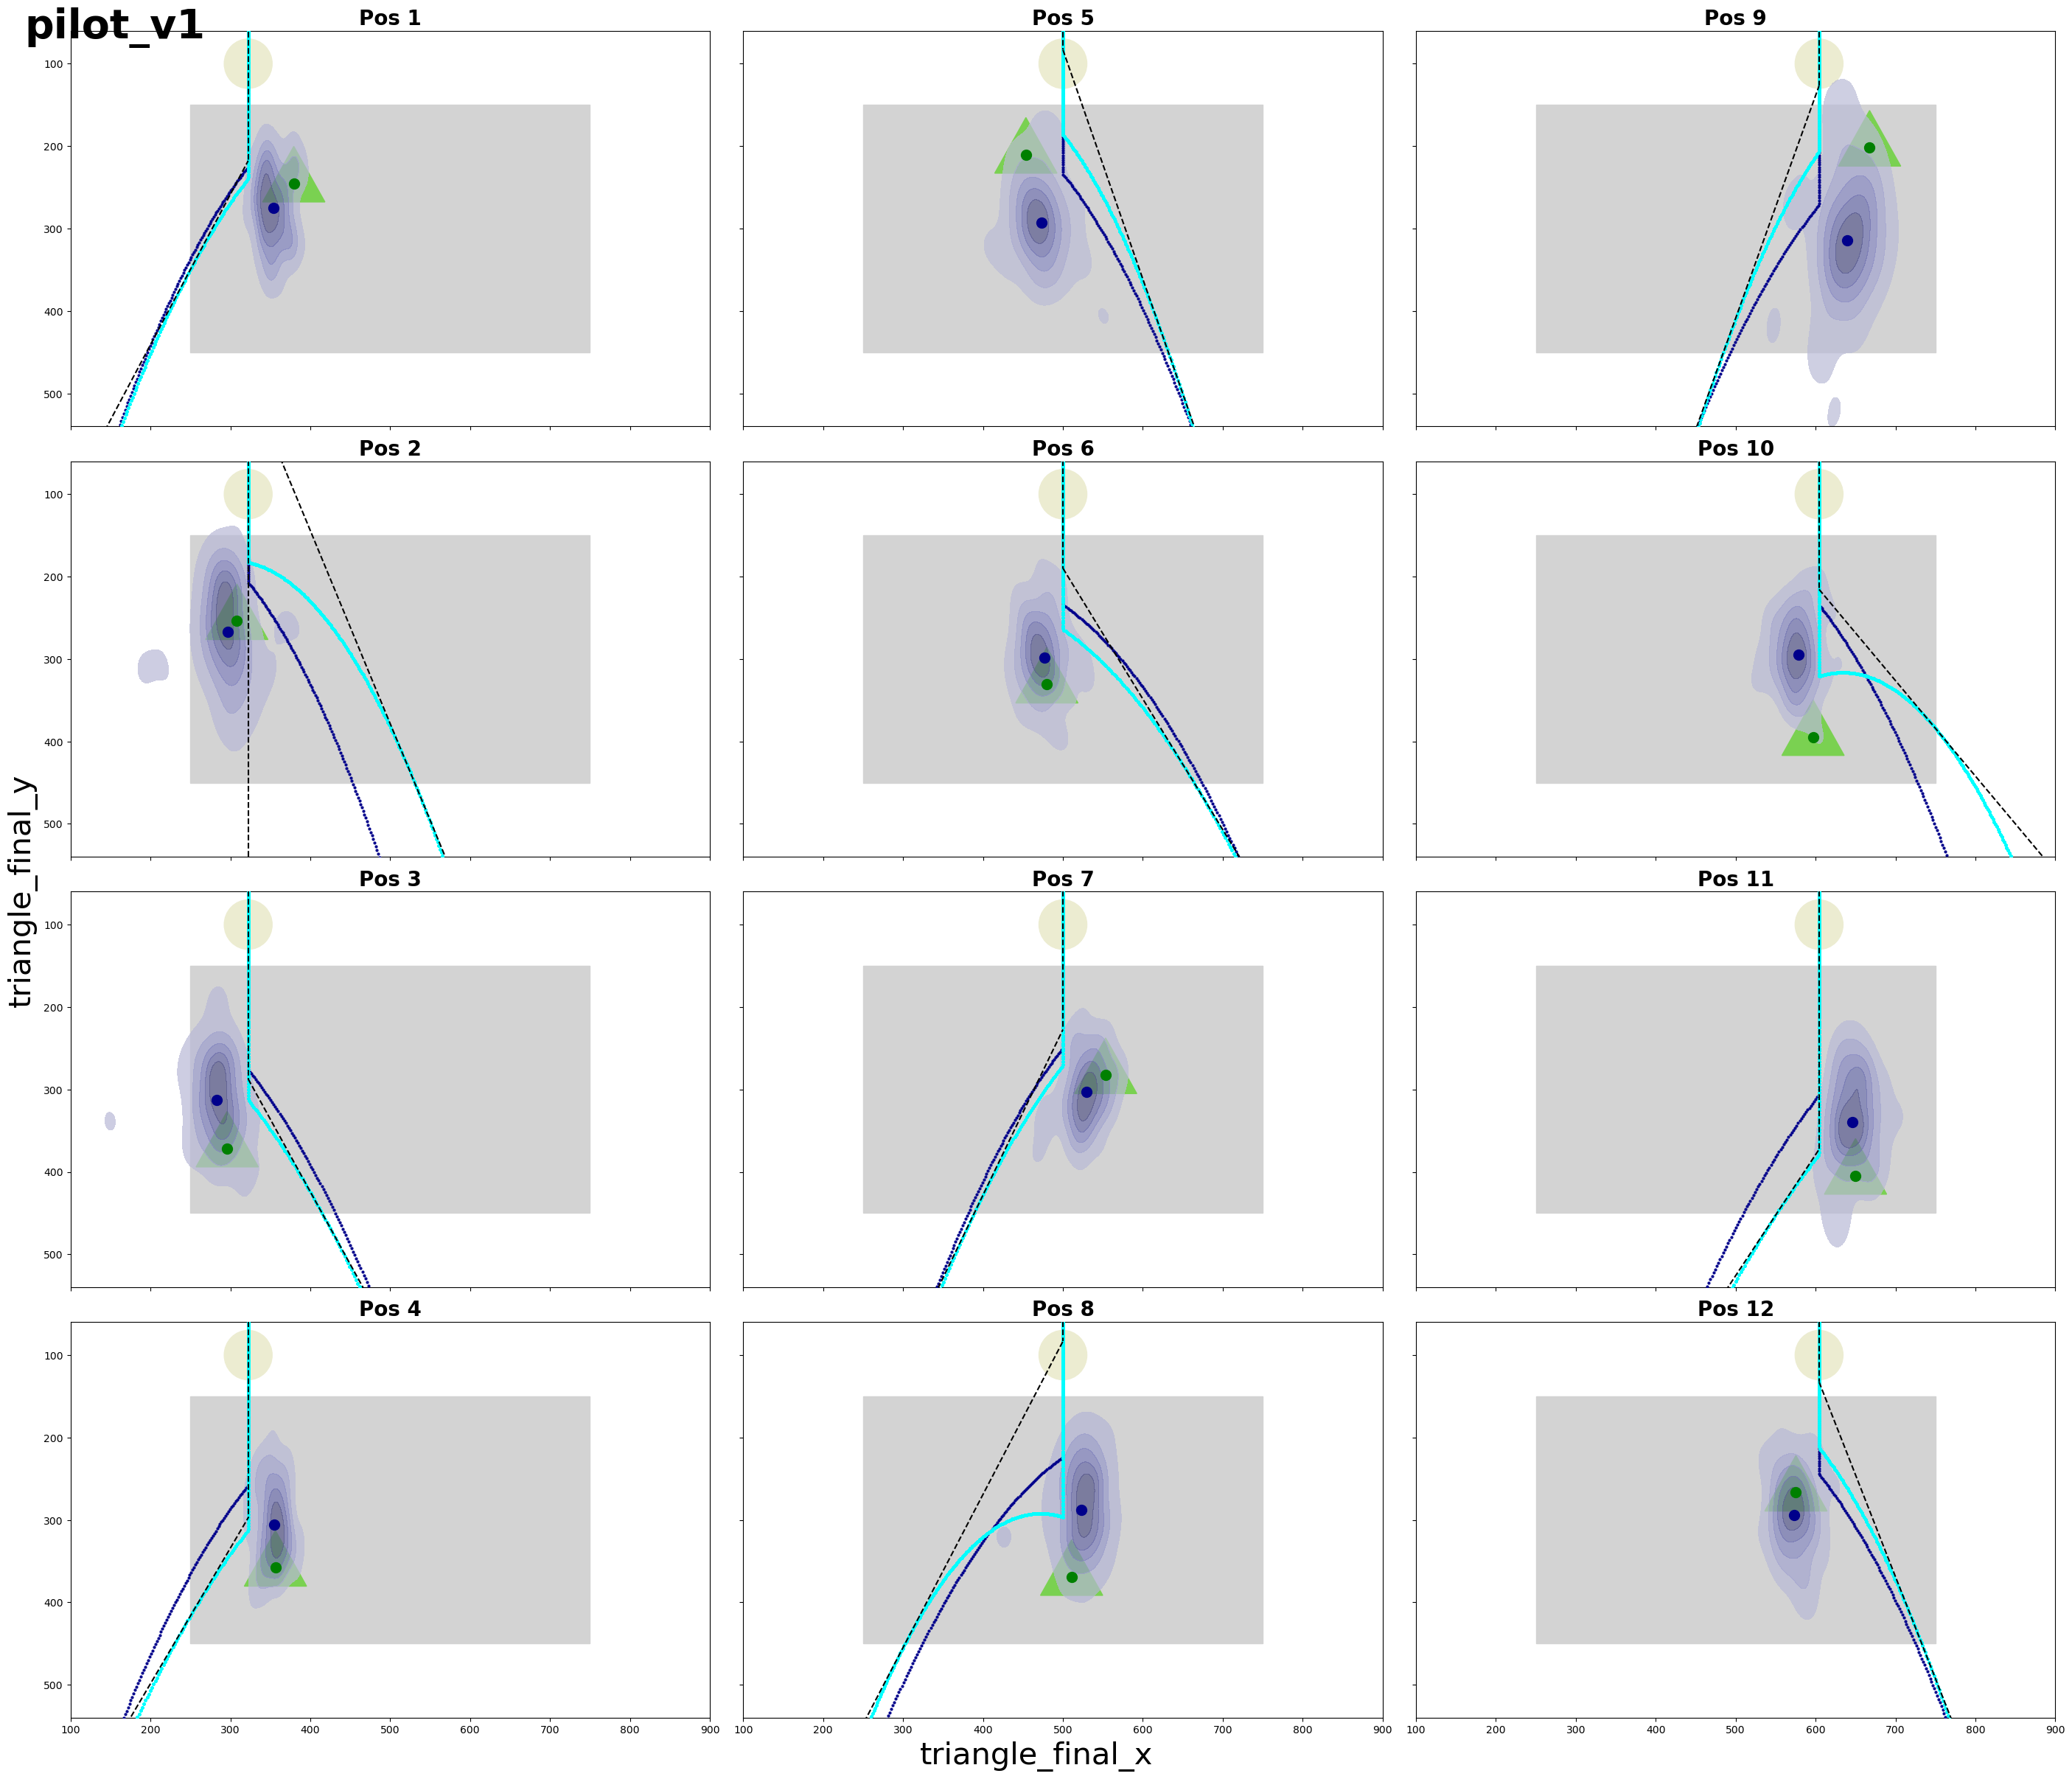

In [39]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = plt.get_cmap('viridis', len(conditions))

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24), sharex=True, sharey=True, layout = 'constrained')  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    ax.scatter(x_coord,y_coord, color='green', label="Intersection", s = 100, zorder = 20)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color=color_map(4), fill=True) #color_map(4) '#ff603b'
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
#     for i, condition in enumerate(conditions):
    subset = df_all[df_all['stimulus_idx'] == position]
    sns.kdeplot(subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map(1), levels=6, thresh=.1, common_grid = True, ax=ax, fill = True, alpha = 0.7) #bw_adjust = 0.8
    
    # plot human response centroid
    centroid_x = subset['triangle_final_x_flipback'].mean()
    centroid_y = subset['triangle_final_y'].mean()
    ax.scatter(centroid_x,centroid_y, color='darkblue', label="Intersection", s = 100, zorder = 20)
    
    # plot the trajectory
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    # plot the simulated trajectory
    drawSimulatedTrajectory(position, 'simulated_trial', df_simulated, ax, 6)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'Pos {int(position)}', weight='bold', fontsize=20)
#     ax.legend()

fig.supxlabel('triangle_final_x', fontsize=30)  # Common xlabel for the figure
fig.supylabel('triangle_final_y', fontsize=30)  # Common ylabel for the figure
# plt.tight_layout()  # Optional, improves appearance
# fig.legend(handles, labels, loc='upper right')

fig.text(0.01, 0.999, 'pilot_v1', weight='bold', va='top', fontsize=40)  # 0.01, 0.99 corresponds to the top-left corner
plt.savefig('KDE plot.pdf')
plt.show()

### Contour Plot without marginal distribution (color_map = 'viridis')

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = plt.get_cmap('viridis', len(conditions))

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#ff603b', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        sns.kdeplot(subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map(i), levels=4, thresh=.2, common_grid = True, ax=ax)#bw_adjust = 0.8
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map(i), linewidth=4, s=100, zorder = 11)  
    
        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # plot the trajectory
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
fig.text(0.01, 0.999, 'pilot_v1', weight='bold', va='top', fontsize=40)  # 0.01, 0.99 corresponds to the top-left corner
plt.show()

### Contour Plot with Color_left, mid, right (red, gray, blue) + trajectory

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2: 'red', 3: '#757575', 4: '#757575', 5: '#0088DE', 6: '#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1', zorder = 1)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='green', fill=True, zorder = 3)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray', zorder = 2)
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        sns.kdeplot(subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map[i+1], levels=4, thresh=.2, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 5)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1], linewidth=4, s=100, zorder= 6)  
    
        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
     # plot the trajectory
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
plt.show()

### if KDE is generated based on left, mid, right groups

In [ ]:
## if want to group the responses in to 3 groups (above is 6-group):
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2: 'red', 3: '#757575', 4: '#757575', 5: '#0088DE', 6: '#0088DE'}

# left, mid, right
group_assignment = {'left': [1,2], 'mid': [3,4], 'right': [5,6]}

# group_color
group_color = {'left':'red', 'mid':'#757575', 'right':'#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#5fa55a', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        
        
        # Plot initial positions
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white',linewidth=5, s=130, zorder=10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1],linewidth=3, s=100, zorder=10)  

        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    for group in group_assignment:
        group_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(group_assignment[group]))]
        sns.kdeplot(group_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=group_color[group], levels=4, thresh=.2, common_grid = True, ax=ax, fill=True, alpha = 0.6, zorder = 4)#bw_adjust = 0.8
        
    # plot the trajectory
    drawTrajectory(position, trajectory_df, ax, 7)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
fig.legend(handles, labels, loc='upper right')

# add color bar
# cax = fig.add_axes([1.05, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
# cb = ColorbarBase(cax, cmap=hsv, orientation='vertical', norm=plt.Normalize(vmin=global_min, vmax=global_max))
# cb.set_label('Speed Value')
plt.show()

### If KDE is generated based on the grouping of near/far

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {'near': 'red', 'far': '#0088DE'}

theta = 231.6

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1', zorder = 1)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='green', fill=True, zorder = 3)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray', zorder = 2)
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    # Create Empty Lists to hold grouping labels
    nearGroup = []
    farGroup = []
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        distance = subset['anchor2Path'].unique()[0]
        if distance <= theta:
            color = color_map['near']
            nearGroup.append(condition)
        else:
            color = color_map['far']
            farGroup.append(condition)
    
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 5)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color, linewidth=4, s=100, zorder= 6)  
    
        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # near group kde
#     print(nearGroup, farGroup)
    near_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(nearGroup))]
    sns.kdeplot(near_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['near'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
    # far group kde
    far_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(farGroup))]
    sns.kdeplot(far_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['far'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
    
    
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
#     drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
plt.show()

### If only near groups' KDE is generated

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = plt.get_cmap('viridis', len(conditions))

theta = 231.6

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1', zorder = 1)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#ff603b', fill=True, zorder = 3)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray', zorder = 2)
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    # Create Empty Lists to hold grouping labels
    nearGroup = []
    farGroup = []
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        distance = subset['anchor2Path'].unique()[0]
        if distance <= theta:
            sns.kdeplot(subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map(i), levels=4, thresh=.2, common_grid = True, ax=ax, fill=False, zorder = 4)
            cluster_color = color_map(i)
        else:
            cluster_color = 'white'
    
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 5)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=cluster_color, linewidth=4, s=100, zorder= 6)  
    
        # Add handles and labels to lists
        if index == 1:
            if len(handles) < len(conditions):
                handles.append(scatter)
                labels.append(f'Initial position: {int(condition)}')
    
    # near group kde
#     print(nearGroup, farGroup)
#     near_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(nearGroup))]
#     sns.kdeplot(near_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['near'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
#     # far group kde
#     far_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(farGroup))]
#     sns.kdeplot(far_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['far'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
    
    
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
#     drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
plt.show()

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {'near': 'red', 'far': '#0088DE'}

theta = 181.9

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1', zorder = 1)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='green', fill=True, zorder = 3)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray', zorder = 2)
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    # Create Empty Lists to hold grouping labels
    nearGroup = []
    farGroup = []
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        distance = subset['anchor2Path'].unique()[0]
        if distance <= theta:
            color = color_map['near']
            nearGroup.append(condition)
        else:
            color = color_map['far']
            farGroup.append(condition)
    
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 5)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color, linewidth=4, s=100, zorder= 6)  
    
        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # near group kde
#     print(nearGroup, farGroup)
    near_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(nearGroup))]
    sns.kdeplot(near_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['near'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
    # far group kde
    far_subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'].isin(farGroup))]
    sns.kdeplot(far_subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map['far'], levels=5, thresh=.15, common_grid = True, ax=ax, fill=True, alpha = 0.5, zorder = 4)#bw_adjust = 0.8
    
    
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
plt.show()

### Contour Plot with Color_upper, bottom

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2:  '#0088DE', 3: 'red', 4:  '#0088DE', 5: 'red', 6: '#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()
# print(positions)

fig, axs = plt.subplots(4, 3, figsize=(28, 24))  # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object
    
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1', zorder = 1)
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='green', fill=True, zorder = 3)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray', zorder = 2)
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        if i+1 in [1, 3, 5]:
            zorder = 4
        else: zorder = 5
        sns.kdeplot(subset,x="triangle_final_x_flipback", y="triangle_final_y", color=color_map[i+1], levels=4, thresh=.2, common_grid = True, ax=ax, fill=True, alpha = 0.4, zorder = zorder)#bw_adjust = 0.8
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white', linewidth=6, s=120, zorder = 6)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1], linewidth=4, s=100, zorder= 7)  
    
        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
#     ax.legend()

plt.tight_layout()  # Optional, improves appearance
fig.legend(handles, labels, loc='upper right')
plt.show()

## Scatter Plots

### Scatter Plot with dot size == count (color_map = 'viridis') + trajectory

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = plt.get_cmap('viridis', len(conditions))

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#ff603b', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        ax.scatter(subset["triangle_final_x_flipback"], subset["triangle_final_y"], s=50, color=color_map(i), alpha = 0.6)
        
        # Plot initial positions
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white',linewidth=5, s=130, zorder=10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map(i),linewidth=3, s=100, zorder=10)  

        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # plot the trajectory
    drawTrajectory(position, trajectory_df, ax, 7, False)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
fig.legend(handles, labels, loc='upper right')
plt.show()

### Scatter Plot with dot size == count + Color_left, mid, right (red, gray, blue) + trajectory

In [ ]:
conditions = np.sort(df_all['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2: 'red', 3: '#757575', 4: '#757575', 5: '#0088DE', 6: '#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#5fa55a', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_all[(df_all['stimulus_idx'] == position) & (df_all['obstacle_idx'] == condition)]
        
        # Bin data and get bin counts
        ret = binned_statistic_2d(subset["triangle_final_x_flipback"], subset["triangle_final_y"], None, 'count', bins=[np.linspace(0,1000,301),np.linspace(0,600,181)])
        x_bin_centers = (ret.x_edge[1:] + ret.x_edge[:-1]) / 2
        y_bin_centers = (ret.y_edge[1:] + ret.y_edge[:-1]) / 2
        x_center, y_center = np.meshgrid(x_bin_centers, y_bin_centers)
        
        # Plot scatter plot where the size is proportional to the bin count
        size = ret.statistic.T.flatten()
        ax.scatter(x_center.flatten(), y_center.flatten(), s=size*100, color=color_map[i+1], alpha = 0.6)
        
        # Plot initial positions
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white',linewidth=5, s=130, zorder=10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1],linewidth=3, s=100, zorder=10)  

        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # plot the trajectory
#     drawTrajectory(position, trajectory_df, ax, 7)
    
    # plot the projected path
    drawProjectedPath(position, merged_trajectory, ax, 7)
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
# add color bar
# cax = fig.add_axes([1.05, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
# cb = ColorbarBase(cax, cmap=hsv, orientation='vertical', norm=plt.Normalize(vmin=global_min, vmax=global_max))
# cb.set_label('Speed Value')

fig.legend(handles, labels, loc='upper right')
plt.show()

# Mixed Effect Regression (LME)

In [11]:
df_all

,participant_ID,currentTrial,subject_id,study_id,session_id,trial_index,trial_name,flipped,ball_X,triangle_final_x,...,obstacle_groundTruth_y,stimulus_idx,obstacle_idx,obstacle_initial_x,obstacle_initial_y,runnerFPS,ball_X_final,obstacle_groundTruth_x_final,obstacle_initial_x_final,triangle_final_x_flipback
0,60fdb8ef572006d42ee49b20_result,1.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,29,fallScene,False,500.0,497.000000,...,330.87,6.0,4.0,500.0,350.0,60.000000,500.0,479.921143,500.0,497.000000
1,60fdb8ef572006d42ee49b20_result,2.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,31,fallScene,False,322.3,360.000002,...,245.25,1.0,2.0,375.0,350.0,60.000000,322.3,379.371143,375.0,360.000002
2,60fdb8ef572006d42ee49b20_result,3.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,33,fallScene,False,322.3,378.010000,...,245.25,1.0,3.0,500.0,250.0,60.000000,322.3,379.371143,500.0,378.010000
3,60fdb8ef572006d42ee49b20_result,4.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,35,fallScene,False,500.0,489.010000,...,210.33,5.0,3.0,500.0,250.0,60.000000,500.0,453.671143,500.0,489.010000
4,60fdb8ef572006d42ee49b20_result,5.0,60fdb8ef572006d42ee49b20,6509bb9f610e9a3075ec3f2e,650e0cef2fa669e369cb8f10,37,fallScene,True,322.3,650.999930,...,357.87,4.0,6.0,625.0,350.0,60.000000,677.7,643.578857,375.0,349.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,5ec75df0d799ae1c11a8115c_result,68.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,155,fallScene,True,500.0,527.000000,...,210.33,5.0,3.0,500.0,250.0,60.007740,500.0,546.328857,500.0,473.000000
1436,5ec75df0d799ae1c11a8115c_result,69.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,157,fallScene,True,500.0,537.994224,...,210.33,5.0,4.0,500.0,350.0,62.011746,500.0,546.328857,500.0,462.005776
1437,5ec75df0d799ae1c11a8115c_result,70.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,159,fallScene,True,500.0,474.000007,...,282.51,7.0,6.0,625.0,350.0,60.016380,500.0,446.528857,375.0,525.999993
1438,5ec75df0d799ae1c11a8115c_result,71.0,5ec75df0d799ae1c11a8115c,6509bb9f610e9a3075ec3f2e,650e0f52a698077237c86766,161,fallScene,True,604.4,455.010000,...,394.50,10.0,1.0,375.0,250.0,62.016626,395.6,403.128857,625.0,544.990000


In [12]:
trajectory_df

,trial_index,trail,flipped,stimulus_idx,currentTrial
0,0,None,None,NaN,NaN
1,1,"[{""position"":{""x"":157.40552600496406,""y"":595.8...",False,4.0,1.0
2,2,"[{""position"":{""x"":585.7437268715564,""y"":596.02...",False,2.0,2.0
3,3,"[{""position"":{""x"":489.9495257109823,""y"":599.90...",False,3.0,3.0
4,4,"[{""position"":{""x"":157.40552600496406,""y"":595.8...",False,4.0,4.0
...,...,...,...,...,...
68,68,"[{""position"":{""x"":141.56393523822751,""y"":598.0...",False,1.0,68.0
69,69,"[{""position"":{""x"":786.4249227148599,""y"":597.26...",False,12.0,69.0
70,70,"[{""position"":{""x"":745.1542440234385,""y"":598.13...",False,6.0,70.0
71,71,"[{""position"":{""x"":745.1542440234385,""y"":598.13...",False,6.0,71.0


No matter the scene has been flipped or not, the value of delta with/without flip should be the same. Since there are 6 anchors and 12 different trajectories, we should have 6*12 different value of deltas (delta_0). 
1. Create a dataframe that stores the path (in format of (x, y) tuples) for each trajectory (stimulus_idx)
2. Merge the dataframe to df_all
3. Create a function that finds the shortest distance between the anchor and the trajectory
4. Create a new column in df_all that calculates the distance (delta_0) for each trial (how about only difference in certain axis?)  
    - Create a new column in df_all that calculates the distance between the anchor and groundtruth (delta_1) for each trial (how about only difference in certain axis?)  
5. Create a binary column in df_all that indicate whether delta < theta for a certain level of theta
6. Conduct Mixed Effect Regression for one value of theta
7. Conduct Mixed Effect Regression for multiple values of theta (grid)
8. Plot the loglikelihood of the model (y axis) as a factor of the theta value (x axis)

### 1. Create a dataframe that stores the path (in format of (x, y) tuples) for each trajectory (stimulus_idx) ###

1. Generate Trajectory Data
    - 72 trials: 12*6
    - No Flip (after checking, flipping does not change the trajectory)
    - Change string output to list of tuples (add a column to the trajectory_df)

2. Merge the 6 trials into one trajectory
    - concate trials with the same simulus index, remove redundant coordinates (notice that the speed could be tricky when concatenating -> when put the speed back, might not form a consistent movement)
    
3. resulting dataframe columns: stimulus_idx, trail; (12 rows in total)

In [13]:
# init-process
filename = 'getTrajectory/trajectory_withoutFlip_72_200fps.csv'
trajectory_df = preprocessTrajectoryData(filename)
trajectory_df = trajectory_df[pd.notna(trajectory_df['trail'])]

# Change string output to list of tuples (add column to the trajectory_df)
# `path_and_speed`: (x,y,s) tuples
def getExactPathSpeed(dataString):
    dataList = json.loads(dataString)
    path = [(item['position']['x'], item['position']['y'], item['speed']) for item in dataList]
    return path
    
trajectory_df['exact_path'] = trajectory_df['trail'].apply(getExactPathSpeed)

# concate trials with the same simulus index, remove redundant coordinates 
# (notice that the speed could be tricky when concatenating -> when put the speed back, might not form a consistent movement)
merged_trajectory = trajectory_df.groupby('stimulus_idx').agg({
    'exact_path': lambda x: list(set([item for sublist in x for item in sublist]))
}).reset_index()

In [14]:
# # visualization for code checking
# plt.scatter([item[0] for item in merged_trajectory['exact_path'].loc[1]], [item[1] for item in merged_trajectory['exact_path'].loc[1]], c=[item[2] for item in merged_trajectory['exact_path'].loc[1]], cmap='hsv', s=4)
# plt.show()

In [15]:
merged_trajectory

,stimulus_idx,exact_path
0,1.0,"[(186.17265736037794, 483.7814036672886, 14.68..."
1,2.0,"[(525.1058629425622, 437.35126930118565, 12.97..."
2,3.0,"[(322.3, 127.01906941304776, 6.499249307053722..."
3,4.0,"[(322.3, 127.01906941304776, 6.499249307053722..."
4,5.0,"[(559.7873597277438, 280.01806091349647, 10.46..."
5,6.0,"[(637.9216223014364, 410.26186651739795, 12.30..."
6,7.0,"[(369.07409200566457, 491.86903583407576, 14.7..."
7,8.0,"[(243.82916576371153, 578.5394551269502, 13.53..."
8,9.0,"[(539.7155615155689, 318.21322068755023, 11.43..."
9,10.0,"[(702.3901273114751, 339.8569598806105, 6.3440..."


In [ ]:
# len(merged_trajectory['exact_path'].loc[5]) # 247

In [ ]:
# merged_trajectory['exact_path'].loc[5]

### 2. Merge the dataframe to df_all

In [16]:
df_all = df_all.merge(merged_trajectory, on='stimulus_idx', how='left')

In [ ]:
# Save the cleaned data to a new CSV file
# df_all.to_csv('data_all/df_all_with_trajectory_pilot_v1.csv', index=False)

#### 2.1 Find the projected path based on the trajectory

In [17]:
# Find the vertical line first
projected_line_0 = df_all.groupby(['stimulus_idx'])['ball_X'].mean() # since all ball_X will be the same, so okay to use either mean, min, or max

In [18]:
merged_trajectory = merged_trajectory.merge(projected_line_0, on='stimulus_idx', how='left')

In [19]:
merged_trajectory = merged_trajectory.rename(columns={'ball_X':'projected_line_0'})

In [20]:
# Function to get the first two elements of each tuple
def take_first_two(lst):
    return [(a, b) for a, b, _ in lst]

merged_trajectory['exact_path_no_speed'] = merged_trajectory['exact_path'].apply(take_first_two)

In [21]:
merged_trajectory.loc[0, 'exact_path_no_speed']

[(186.17265736037794, 483.7814036672886),
 (322.3, 127.01906941304776),
 (322.3, 77.02378391513162),
 (273.68448863420514, 308.75425852763715),
 (247.9443248196692, 353.48552950628664),
 (322.3, 80.62353005181663),
 (322.3, 50.69999580001577),
 (211.9100413831633, 425.5556721381925),
 (322.3, 178.76212345609736),
 (155.28932529695635, 561.0736447795196),
 (150.14226542217696, 574.7427709161478),
 (322.3, 51.949978550160935),
 (322.3, 228.47893884814758),
 (322.3, 50.074999925),
 (227.3530277343365, 393.31902412287315),
 (287.41304962902353, 287.19679670341077),
 (322.3, 73.64900673054375),
 (322.3, 60.87469550616637),
 (322.3, 237.55230546754365),
 (322.3, 106.94624148323),
 (244.5123904935879, 359.87454348500205),
 (270.2523998673726, 314.3935420185757),
 (314.87116009630375, 248.88042408601925),
 (189.60424164648515, 475.6931254830497),
 (295.99356756937897, 274.5356288602583),
 (215.34178009426967, 418.2170479730055),
 (322.3, 71.52413902518416),
 (175.8780280384112, 508.64594374360

In [22]:
segmented_line = [((250, 150), (250, 450)), ((250, 450), (750, 450)), ((750, 450), (750, 150))]

# Create a function that find the two consecutive coordinates of the ball when it is about to fall outside of the screen
def distance_to_segment(point, segment):
    """Calculate the distance from a point to a line segment."""
    return Point(point).distance(LineString(segment))

def closest_points_to_line(points, segmented_line = segmented_line):
    """Find two points that are nearest to the segmented line and are also near each other."""
    # Calculate distances from all points to the segmented line
    distances = [min(distance_to_segment(point, segment) for segment in segmented_line) for point in points]
    
    # Sort points based on their distance to the segmented line
    sorted_points = sorted(points, key=lambda p: min(distance_to_segment(p, segment) for segment in segmented_line))
    
    for point in sorted_points:
        # Sort other points based on their distance to the current point
        other_points = sorted(points, key=lambda p: np.linalg.norm(np.array(point) - np.array(p)))
        for near_point in other_points[1:3]:  # considering the 2 nearest points
            if abs(distances[points.index(point)] - distances[points.index(near_point)]) < 5:
                return point, near_point
    return None

points = merged_trajectory.loc[0, 'exact_path_no_speed']

print(closest_points_to_line(points, segmented_line))
merged_trajectory['projected_line_1'] = merged_trajectory['exact_path_no_speed'].apply(closest_points_to_line)

((249.6602997045891, 350.3285082728476), (251.37627973744912, 347.1964776433167))


In [ ]:
merged_trajectory

In [ ]:
projected_line_0.iloc[0]

In [ ]:
projected_line_1

In [23]:
# Given data
x_vertical = projected_line_0.iloc[0]
point1 = projected_line_1.iloc[0][0]
point2 = projected_line_1.iloc[0][1]

# Calculate slope
if (point2[0] - point1[0]) == 0:
    slope = float('inf')
else:
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])

# Calculate extended points based on the slope
x_extended_1 = 100  # for instance, at the far left of the plot
y_extended_1 = point1[1] + slope * (x_extended_1 - point1[0])

x_extended_2 = 900  # for instance, at the far right of the plot
y_extended_2 = point1[1] + slope * (x_extended_2 - point1[0])
print((x_extended_1, y_extended_1), (x_extended_2, y_extended_2))

# Create the two line segments
vertical_line = LineString([(x_vertical, 0), (x_vertical, 600)])  # assuming a large y range for the vertical line
extended_line = LineString([(x_extended_1, y_extended_1), (x_extended_2, y_extended_2)])

# Calculate intersection
intersection = vertical_line.intersection(extended_line)

# Plotting
plt.plot([x_vertical, x_vertical], [0, 600], label="Vertical Line")  # using a large y range for visualization
plt.plot([x_extended_1, x_extended_2], [y_extended_1, y_extended_2], label="Extended Line", linestyle='--', color='black')
plt.scatter(*intersection.xy, color='red', label="Intersection")
plt.legend()
# plt.grid(True)
plt.show()

NameError: name 'projected_line_1' is not defined

In [ ]:
intersection.y

In [ ]:
merged_trajectory[merged_trajectory['stimulus_idx']==1]['projected_line_1'][0]

In [24]:
def drawProjectedPath(condition, merged_trajectory, ax, zorder):
    # Given data
    subset = merged_trajectory[merged_trajectory['stimulus_idx']==condition]
#     print(subset['projected_line_0'])
    x_vertical = subset['projected_line_0'].iloc[0]
    point1 = subset['projected_line_1'].iloc[0][0]
    point2 = subset['projected_line_1'].iloc[0][1]
    
    # Calculate slope
    if (point2[0] - point1[0]) == 0:
        slope = float('inf')
    else:
        slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
        
        
    # Calculate extended points based on the slope
    x_extended_1 = 100  # at the far left of the plot
    y_extended_1 = point1[1] + slope * (x_extended_1 - point1[0])

    x_extended_2 = 900  # at the far right of the plot
    y_extended_2 = point1[1] + slope * (x_extended_2 - point1[0])
    
    # Create the two line segments
    vertical_line = LineString([(x_vertical, 0), (x_vertical, 600)])  # assuming a large y range for the vertical line
    extended_line = LineString([(x_extended_1, y_extended_1), (x_extended_2, y_extended_2)])
    
    # Calculate intersection
    intersection = vertical_line.intersection(extended_line)

    # Plotting
    if intersection and 100 <= intersection.x <= 900 and 60 <= intersection.y <= 540:
        ax.plot([x_vertical, x_vertical], [0, intersection.y], label="Vertical Line", linestyle='--', color='black', zorder = zorder) 
        if intersection.y <= y_extended_1:
            ax.plot([x_extended_1, intersection.x], [y_extended_1, intersection.y], label="Extended Line", linestyle='--', color='black', zorder = zorder)
        else:
            ax.plot([intersection.x, x_extended_2], [intersection.y, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
#         ax.scatter(*intersection.xy, color='red', label="Intersection")
    else:
        ax.plot([x_vertical, x_vertical], [0, 600], label="Vertical Line", linestyle='--', color='black', zorder = zorder)  # using a large y range for visualization
        ax.plot([x_extended_1, x_extended_2], [y_extended_1, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
#         ax.scatter(*intersection.xy, color='red', label="Intersection")

### 3. Create a function that finds the shortest distance between the anchor and the trajectory

Notice all the trajectories are **non-flipped**, so we can just use the obstacle_initial_x, obstacle_initial_y (**NOT the FINAL versions**)

1. A function that calculate the Euclidean distance between two points
2. A function that calculate the shortest distance bewtween the point and a list of points

In [ ]:
# A function that calculate the Euclidean distance between two points
def getDistance2Points(x_0, y_0, x_1, y_1):
    return ((x_1-x_0)**2 + (y_1-y_0)**2)**0.5

# A function that calculate the shortest distance bewtween the point and a list of points
def getDistancePointList(x_0, y_0, path): # path is a list containing (x,y,s) tuples
    minDis = -1
    bestCoord = None
    for item in path:
#         print(item)
        x_1, y_1 = item[0], item[1]
        distance = getDistance2Points(x_0, y_0, x_1, y_1)
        if distance <= minDis or minDis < 0:
            minDis = distance
            bestCoord = item
#     print(bestCoord)
    return minDis

###  4. Create a new column in df_all that calculates the distance (delta_0) for each trial (how about only difference in certain axis?)  

Can create multiple columns:

    - anchor to trajectory (`anchor2Path`) <- for both models 
    - anchor to groundTruth (`anchor2Truth`) <- for both models 
    - anchor_x to groundTruth_x (`anchor_x2Truth_x`) <- in x_coord model
    - anchor_y to groundTruth_y (`anchor_y2Truth_y`) <- in y_coord model

In [ ]:
df_all

In [ ]:
# Create a new column: shortest distance between anchor to trajectory (`anchor2Path`)
df_all['anchor2Path'] = df_all.apply(lambda row: getDistancePointList(row['obstacle_initial_x'], row['obstacle_initial_y'], row['exact_path']), axis=1)
cols = ['stimulus_idx', 'obstacle_idx', 'obstacle_initial_x', 'obstacle_initial_y', 'exact_path', 'anchor2Path']
df_all[cols]

In [ ]:
# Create a new column: distance between anchor and groundTruth (`anchor2Truth`)
df_all['anchor2Truth'] = df_all.apply(lambda row: getDistance2Points(row['obstacle_initial_x'], row['obstacle_initial_y'], row['obstacle_groundTruth_x'], row['obstacle_groundTruth_y']), axis=1)
cols = ['stimulus_idx', 'obstacle_idx', 'obstacle_initial_x', 'obstacle_initial_y', 'exact_path', 'anchor2Truth']
df_all[cols]

In [ ]:
# anchor_x to groundTruth_x (`anchor_x2Truth_x`) <- in x_coord model
# anchor_y to groundTruth_y (`anchor_y2Truth_y`) <- in y_coord model
df_all['anchor_x2Truth_x'] = abs(df_all['obstacle_initial_x'] - df_all['obstacle_groundTruth_x'])
df_all['anchor_y2Truth_y'] = abs(df_all['obstacle_initial_y'] - df_all['obstacle_groundTruth_y'])

In [ ]:
df_all

### 5. Create a binary column in df_all that indicate whether delta < theta for a certain level of theta

In [ ]:
df_all['anchor2Path'] > 100

In [ ]:
theta = 200 
# entry = 1 if delta <= theta, else 0

def add_Indicator_and_Result(colName,theta, dataframe, indicatorReversed = False):
    if indicatorReversed:
        dataframe[f'{colName}_binary'] = np.where(dataframe[colName] <= theta, 0, 1)
        dataframe[f'obstacle_initial_x_final_filtered'] = dataframe[f'{colName}_binary']*dataframe['obstacle_initial_x_final']
    else:
        dataframe[f'{colName}_binary'] = np.where(dataframe[colName] <= theta, 1, 0)
        dataframe[f'obstacle_initial_x_final_filtered'] = dataframe[f'{colName}_binary']*dataframe['obstacle_initial_x_final']
    return dataframe
df_100 = add_Indicator_and_Result('anchor2Path', 100, df_all, False)

In [ ]:
df_100

### 6. Conduct Mixed Effect Regression for one value of theta

In [ ]:
# Fit the model to x-coord
model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_100, groups=df_100["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
result = model_x.fit()
print(result.summary())

In [ ]:
# how to get the extract the p-value of a particular variable in the results of a mixed linear model fitted with the statsmodels library
# float(result.summary().tables[1].loc['obstacle_initial_x_final_filtered', 'P>|z|']) <= 0.05
# or, more conviniently
result.pvalues['obstacle_initial_x_final_filtered']

In [ ]:
'obstacle_initial_x_final_filtered' in result.pvalues

In [ ]:
df_1000 = add_Indicator_and_Result('anchor2Path', 1000, df_all)

In [ ]:
# Fit the model to x-coord
model_x_1000 = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_1000, groups=df_1000["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
result = model_x_1000.fit()
print(result.summary())

In [ ]:

# Fit the model to x-coord
model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_all, groups=df_all["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
result = model_x.fit()
print(result.summary())


In [ ]:
# Fit the model to x-coord
model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_200, groups=df_200["subject_id"])
result = model_x.fit()
print(result.summary())

In [ ]:
# Fit the model to x-coord
model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_200, groups=df_200["subject_id"], re_formula="~obstacle_initial_x_final_filtered+ obstacle_groundTruth_x_final")
result = model.fit(maxiter=5000000, method= 'powell')
# different methods:  'lbfgs' (default) 'bfgs' 'powell' 'cg' 'basinhopping''nm'
# llk: 'powell' > 'basinhopping'> 'lbfgs' 
# however, using 'powell' will result in error "The MLE may be on the boundary of the parameter space" <- var about 0 (similar to a fixed effect result)
# using 'basinhopping' will result in error "The Hessian matrix at the estimated parameter values is not positive definite." <- not convex (no optimal solution)
# using 'lbfgs' will result in the same error
print(result.summary())

In [ ]:
# Fit the model to x-coord
model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", df_all, groups=df_all["subject_id"], re_formula="~obstacle_groundTruth_x_final")
result = model.fit(maxiter=5000000, method= 'lbfgs')
# different methods:  'lbfgs' (default) 'bfgs' 'powell' 'cg' 'basinhopping''nm'
# llk: 'powell' > 'basinhopping'> 'lbfgs' 
# however, using 'powell' will result in error "The MLE may be on the boundary of the parameter space" <- var about 0 (similar to a fixed effect result)
# using 'basinhopping' will result in error "The Hessian matrix at the estimated parameter values is not positive definite." <- not convex (no optimal solution)
# using 'lbfgs' will result in the same error
print(result.summary())

In [ ]:
grouped = df_all.groupby(['stimulus_idx', 'obstacle_idx'])
descriptive_stats = grouped['anchor2Path'].describe()
descriptive_stats.min

In [ ]:
len(grouped['anchor2Path'].min().values)

In [ ]:
grouped['anchor2Path'].min().values

In [ ]:
max(grouped['anchor2Path'].max())

### 7. Conduct Mixed Effect Regression for all theta values

In [ ]:
# get a list of delta values <- theta values are based on the delta values 
deltaVals = df_all['anchor2Path'].unique() # 72 values -> 63 unique values
thetaVals = np.sort(np.append(deltaVals, [0, 350])) # max(grouped['anchor2Path'].max()) = 322.4949

In [ ]:
thetaVals # 63 unique values + 2 (0+350)

#### x-axis

In [ ]:
# a function that takes the dataframe, adds the binary&filtered column, conduct LME regression based on random effects model specified
# input: 
'''
colName: column name to be used as an indicator
thetaVals: generated based on the value of deltas
steps: number of steps for the value of theta, 
dataframe: the dataframe used for regession, 
optimizer: the optimizer used for model fitting,  (different methods:  'lbfgs' (default) 'bfgs' 'powell' 'cg' 'basinhopping''nm')
maxiter: max iterations specified for model fitting
fixed: True/False, if the slope of obstacle_initial_x_final_filtered & obstacle_groundTruth_x_final are fixed across participants
randomVars: Which variable should be treated as a random effect, [obstacle_initial_x_final_filtered, obstacle_groundTruth_x_final]
indicatorReversed: whether the criteria is reversed
nested: whether to use the binary indicator as trial label
'''
def getLlfPlot(colName, thetaVals, dataframe, optimizer, maxiter, randomVars = [], indicatorReversed = False, nested = False):
    llfList = []
    groupVarList = []
    bestLlf = -float('inf')
    bestTheta = 0
    bestModel = None
    anchorPVals = []
    for theta in thetaVals:
        data_reg = add_Indicator_and_Result(colName, theta, dataframe, indicatorReversed)
        non_zero_count = (data_reg['obstacle_initial_x_final_filtered'] != 0).sum()
        if nested:
            if non_zero_count != len(data_reg['obstacle_initial_x_final_filtered']) and non_zero_count != 0:
                model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final + obstacle_initial_x_final:anchor2Path_binary", 
                                    data=data_reg, 
                                    groups=data_reg["subject_id"], 
                                    re_formula="~obstacle_initial_x_final:anchor2Path_binary + obstacle_groundTruth_x_final")
            else:
                model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final + obstacle_groundTruth_x_final")
        elif non_zero_count == 0 and "obstacle_groundTruth_x_final" in randomVars:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_x_final")
        elif non_zero_count == 0:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"])
        elif len(randomVars) == 0:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"])
        elif len(randomVars) == 2:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
        elif 'obstacle_initial_x_final_filtered' in randomVars:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final_filtered")
            # if try setting starting values for the fixed and random effects
            # starting_values = [60, -0.03, 0.88, 0.05, 0.05, 0.05]
            # model_x.start_params = starting_values
        else:
            model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_x_final")
        result = model_x.fit(maxiter = maxiter, method = optimizer)
#         print(theta)
        
        # record the p-values
        if theta != 0:
            pVal = result.pvalues['obstacle_initial_x_final_filtered']
            anchorPVals.append(pVal)
#             print(pVal)
        
        # record the llf
        modelFit = result.llf
        llfList.append(modelFit)
        groupVarList.append(result.cov_re['Group']['Group']) # extract the coefficient of the Group Var (to see if the model is reasonable)
        if bestLlf <= modelFit:
            bestLlf = modelFit
            bestTheta = theta
            bestModel = result
        if theta == 350:
            print(result.summary())

    # Create the line plot
    plt.plot(thetaVals, llfList, linestyle='-', color='b')

    # Plot the best point
    plt.scatter(bestTheta, bestLlf, color='r', s=20)  # 's' denotes size of the point

    # Annotate the point with text
    plt.annotate(f'({bestTheta:.1f}, {bestLlf:.1f})',  
                 (bestTheta, bestLlf),
                 textcoords="offset points",  # how to position the text
                 xytext=(10,5),  # distance from text to point (x,y)
                 ha='left')

    # Set title and axis labels
    plt.title(f"$\delta$ = {colName}, Optimizer = {optimizer}, Random-Effect Vars: {len(randomVars)}")
    plt.xlabel(r'Value of $\theta$')
    plt.ylabel('Model Log-Likelihood')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
#     return llfList, bestLlf, bestTheta, bestModel, groupVarList
    return anchorPVals, llfList, bestLlf, bestTheta, bestModel, groupVarList

In [ ]:
## start with a simple model first, random intercepts for subjects
## randomVars = []
llfList_0, bestLlf_0, bestTheta_0, bestModel_0, groupVarList_0 = getLlfPlot('anchor2Path', thetaVals, df_all, 'lbfgs', 500000, [])

# for some value of theta, warning message: Random effects covariance is singular

In [ ]:
print(bestModel_0.summary())

In [ ]:
## start with a simple model first, random intercepts for subjects - different optimizer but same results
## randomVars = []
llfList_0_1, bestLlf_0_1, bestTheta_0_1, bestModel_0_1, groupVarList_0_1 = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 500000, [])

# same result as the previous method

In [ ]:
# model_1: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered" for each participant
# method = 'lbfgs'
llfList_1, bestLlf_1, bestTheta_1, bestModel_1, groupVarList_1 = getLlfPlot('anchor2Path', thetaVals, df_all, 'lbfgs', 500000, ["obstacle_initial_x_final_filtered"])

In [ ]:
print(bestModel_1.summary())

In [ ]:
# model_1_1: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered" for each participant
# method = 'powell'
llfList_1_1, bestLlf_1_1, bestTheta_1_1, bestModel_1_1, groupVarList_1_1 = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 500000, ["obstacle_initial_x_final_filtered"])

In [ ]:
print(bestModel_1_1.summary())

In [ ]:
# model_1_2: random intercepts for each participant, random slopes of "obstacle_groundTruth_x_final" for each participant
# method = 'powell'
llfList_1_2, bestLlf_1_2, bestTheta_1_2, bestModel_1_2, groupVarList_1_2 = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 500000, ["obstacle_groundTruth_x_final"])

In [ ]:
print(bestModel_1_2.summary())

In [ ]:
# model_1_3: random intercepts for each participant, random slopes of "obstacle_groundTruth_x_final" for each participant
# method = 'basinhopping'
llfList_1_3, bestLlf_1_3, bestTheta_1_3, bestModel_1_3, groupVarList_1_3 = getLlfPlot('anchor2Path', thetaVals, df_all, 'basinhopping', 5000000, ["obstacle_groundTruth_x_final"])

In [ ]:
bestModel_1_3.summary()

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
# oftern encounter 'ConvergenceWarning: The MLE may be on the boundary of the parameter space.'
anchorPVals_2_0, llfList_2_0, bestLlf_2_0, bestTheta_2_0, bestModel_2_0, groupVarList_2_0 = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 5000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"])

In [ ]:
print(bestModel_2_0.summary())

In [ ]:
## in how many models, is anchor_x a significant predictor?
print(np.array(anchorPVals_2_0) <= 0.05)
count = sum(np.array(anchorPVals_2_0) <= 0.05)
print(count)

In [ ]:
llfList_2_0[-12] # -12 is the second best 

In [ ]:
thetaVals[-12]

In [ ]:
for theta in thetaVals[1:]:
    data_reg_12 = add_Indicator_and_Result('anchor2Path', theta, df_all)
    model_x_12 = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg_12, groups=data_reg_12["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
    print(f'theta Value:{theta}')
    print(model_x_12.fit(method='powell', maxiter=5000000).summary())

In [ ]:
model_x_12.fit(method='powell', maxiter=5000000).summary()

In [ ]:
bestModel_2_0.cov_re['Group']['Group'] # the fitted random-effects covariance matrix (['Group']['Group'] is Group Var)

In [ ]:
bestModel_2_0.cov_params()

In [ ]:
# model_2_1: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final" for each participant
# method = 'lbfgs'
llfList_2_1, bestLlf_2_1, bestTheta_2_1, bestModel_2_1, groupVarList_2_1 = getLlfPlot('anchor2Path', thetaVals, df_all, 'lbfgs', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"])

In [ ]:
# model_nested: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered:binaryIndicator","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
# often encounter convergence warning 'ConvergenceWarning: The MLE may be on the boundary of the parameter space.'
'''
Fixed Effects:
- impact of x_2 on the response
- Task Label could interact with x_1 to affect the response differently
Random Effects:
- there is participant-specific variability in how x_1:taskLabel and x_2 affect the response
'''
llfList_nested, bestLlf_nested, bestTheta_nested, bestModel_nested, groupVarList_nested = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"], False, True)

In [ ]:
print(bestModel_nested.summary())

In [ ]:
# model_nested: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered:binaryIndicator","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
'''
Fixed Effects:
- impact of x_2 on the response
- Task Label could interact with x_1 to affect the response differently
Random Effects:
- there is participant-specific variability in how x_1:taskLabel and x_2 affect the response
'''
llfList_nested_rev, bestLlf_nested_rev, bestTheta_nested_rev, bestModel_nested_rev, groupVarList_nested_rev = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"], True, True)

In [ ]:
bestModel_nested_rev.summary()

### 8. Linear Mixed Effects Models_binary indicator reversed

In [ ]:
# model_2_reversed: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
# often encounter convergence warning 'ConvergenceWarning: The MLE may be on the boundary of the parameter space.'
llfList_2_rev, bestLlf_2_rev, bestTheta_2_rev, bestModel_2_rev, groupVarList_2_rev = getLlfPlot('anchor2Path', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"], True)

In [ ]:
thetaVals[-10]

In [ ]:
print(bestModel_2_rev.summary())

In [ ]:
# Create the line plot for the Group Var coefficient
plt.plot(thetaVals, groupVarList_2_rev, linestyle='-', color='b')

# Plot the best point
plt.scatter(bestTheta_2_rev, groupVarList_2_rev[-10], color='r', s=20)  # -10 is the position of the best theta

# Annotate the point with text
plt.annotate(f'({bestTheta_2_rev:.1f}, {groupVarList_2_rev[-10]:.1f})',  
             (bestTheta_2_rev, groupVarList_2_rev[-10]),
             textcoords="offset points",  # how to position the text
             xytext=(10,5),  # distance from text to point (x,y)
             ha='left')

# Set title and axis labels
plt.title('Value of the variance of the random intercepts across subjects')
plt.xlabel(r'Value of $\theta$')
plt.ylabel('Group Var Coefficient')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
groupVarList_2_rev[-9]

In [ ]:
for theta in thetaVals[:-1]:
    data_reg_rev = add_Indicator_and_Result('anchor2Path', theta, df_all, True)
    model_x_rev = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg_rev, groups=data_reg_rev["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
    print(f'theta Value:{theta}')
    print(model_x_rev.fit(method='powell', maxiter=5000000).summary())

In [ ]:
for theta in thetaVals[:-1]:
    data_reg_rev = add_Indicator_and_Result('anchor2Path', theta, df_all, True)
    model_x_rev = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg_rev, groups=data_reg_rev["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
    print(f'theta Value:{theta}')
    print(model_x_rev.fit(method='lbfgs', maxiter=5000000).summary())
    print(model_x_rev.fit(method='lbfgs', maxiter=5000000).params)

#### y-axis

In [ ]:
def add_Indicator_and_Result_y(colName, theta, dataframe, indicatorReversed = False):
    if indicatorReversed:
        dataframe[f'{colName}_binary'] = np.where(dataframe[colName] <= theta, 0, 1)
        dataframe[f'obstacle_initial_y_filtered'] = dataframe[f'{colName}_binary']*dataframe['obstacle_initial_y']
    else:
        dataframe[f'{colName}_binary'] = np.where(dataframe[colName] <= theta, 1, 0)
        dataframe[f'obstacle_initial_y_filtered'] = dataframe[f'{colName}_binary']*dataframe['obstacle_initial_y']
    return dataframe

In [ ]:
df_y = add_Indicator_and_Result_y('anchor2Path', 100, df_all, indicatorReversed = False)

In [ ]:
# a function that takes the dataframe, adds the binary&filtered column, conduct LME regression based on random effects model specified
# input: 
'''
colName: column name to be used as an indicator
thetaVals: generated based on the value of deltas
steps: number of steps for the value of theta, 
dataframe: the dataframe used for regession, 
optimizer: the optimizer used for model fitting,  (different methods:  'lbfgs' (default) 'bfgs' 'powell' 'cg' 'basinhopping''nm')
maxiter: max iterations specified for model fitting
fixed: True/False, if the slope of obstacle_initial_x_final_filtered & obstacle_groundTruth_x_final are fixed across participants
randomVars: Which variable should be treated as a random effect, [obstacle_initial_x_final_filtered, obstacle_groundTruth_x_final]
indicatorReversed: whether the criteria is reversed
nested: whether to use binary indicator
'''
def getLlfPlot_y(colName, thetaVals, dataframe, optimizer, maxiter, randomVars = [], indicatorReversed = False, nested = False):
    llfList = []
    groupVarList = []
    bestLlf = -float('inf')
    bestTheta = 0
    bestModel = None
    anchorPVals = []
    
    for theta in thetaVals:
        data_reg = add_Indicator_and_Result_y(colName, theta, dataframe, indicatorReversed)
        
        non_zero_count = (data_reg['anchor2Path_binary'] != 0).sum()
        if nested:
            if non_zero_count != len(data_reg['anchor2Path_binary']) and non_zero_count != 0:
                model_y = smf.mixedlm("triangle_final_y ~ obstacle_groundTruth_y + obstacle_initial_y:anchor2Path_binary", 
                                    data=data_reg, 
                                    groups=data_reg["subject_id"], 
                                    re_formula="~obstacle_initial_y:anchor2Path_binary + obstacle_groundTruth_y")
            else:
#                 print('hi_2')
                model_y = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final + obstacle_groundTruth_x_final")
            
        elif non_zero_count == 0 and "obstacle_groundTruth_y" in randomVars:
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_y")
        elif non_zero_count == 0:
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"])
        elif len(randomVars) == 0:
#             print(theta)
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_initial_y_filtered + obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"])
        elif len(randomVars) == 2:
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_initial_y_filtered + obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_y_filtered + obstacle_groundTruth_y")
        elif 'obstacle_initial_y' in randomVars:
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_initial_y_filtered + obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_y_filtered")
            # if try setting starting values for the fixed and random effects
            # starting_values = [60, -0.03, 0.88, 0.05, 0.05, 0.05]
            # model_x.start_params = starting_values
        else:
            model_y = smf.mixedlm("triangle_final_y ~ obstacle_initial_y_filtered + obstacle_groundTruth_y", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_y")
        result = model_y.fit(maxiter = maxiter, method = optimizer)
#         print(theta)

        # record the p-values
        if 'obstacle_initial_y_filtered' in result.pvalues:
            pVal = result.pvalues['obstacle_initial_y_filtered']
            anchorPVals.append(pVal)

        modelFit = result.llf
        llfList.append(modelFit)
        groupVarList.append(result.cov_re['Group']['Group']) # extract the coefficient of the Group Var (to see if the model is reasonable)
        if bestLlf <= modelFit:
            bestLlf = modelFit
            bestTheta = theta
            bestModel = result
        if theta == 350:
            print(result.summary())

    # Create the line plot
    plt.plot(thetaVals, llfList, linestyle='-', color='b')

    # Plot the best point
    plt.scatter(bestTheta, bestLlf, color='r', s=20)  # 's' denotes size of the point

    # Annotate the point with text
    plt.annotate(f'({bestTheta:.1f}, {bestLlf:.1f})',  
                 (bestTheta, bestLlf),
                 textcoords="offset points",  # how to position the text
                 xytext=(10,5),  # distance from text to point (x,y)
                 ha='left')

    # Set title and axis labels
    plt.title(f"$\delta$ = {colName}, Optimizer = {optimizer}, Random-Effect Vars: {len(randomVars)}")
    plt.xlabel(r'Value of $\theta$')
    plt.ylabel('Model Log-Likelihood')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    return anchorPVals, llfList, bestLlf, bestTheta, bestModel, groupVarList

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_y_filtered","obstacle_groundTruth_y" for each participant
# method = 'powell'
anchorPVals_2_0_y, llfList_2_0_y, bestLlf_2_0_y, bestTheta_2_0_y, bestModel_2_0_y, groupVarList_2_0_y = getLlfPlot_y('anchor2Path', thetaVals, df_all, 'powell',
                                                                                                  5000, ["obstacle_initial_y_filtered","obstacle_groundTruth_y"], 
                                                                                                  False)


In [ ]:
print(bestModel_2_0_y.summary())

In [ ]:
print(np.array(anchorPVals_2_0_y) <= 0.05)
count = sum(np.array(anchorPVals_2_0_y) <= 0.05)
print(count)

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_y_filtered","obstacle_groundTruth_y" for each participant
# method = 'powell'
llfList_2_rev_y, bestLlf_2_rev_y, bestTheta_2_rev_y, bestModel_2_rev_y, groupVarList_2_rev_y = getLlfPlot_y('anchor2Path', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_y_filtered","obstacle_groundTruth_y"], True)

In [ ]:
bestModel_2_rev_y.summary()

In [ ]:
# model_nested: random intercepts for each participant, random slopes of "obstacle_initial_y:anchor2Path_binary","obstacle_groundTruth_y" for each participant
# method = 'powell'
llfList_nested_y, bestLlf_nested_y, bestTheta_nested_y, bestModel_nested_y, groupVarList_nested_y = getLlfPlot_y('anchor2Path', thetaVals, df_all, 'powell',
                                                                                                  5000000, ["obstacle_initial_y_filtered","obstacle_groundTruth_y"], 
                                                                                                  False, True)

In [ ]:
bestModel_nested_y.summary()

### anchor2Truth

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
llfList_truth, bestLlf_truth, bestTheta_truth, bestModel_truth, groupVarList_truth = getLlfPlot('anchor2Truth', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"])

In [ ]:
bestModel_truth.summary()

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final" for each participant
# method = 'powell'
llfList_truth_x, bestLlf_truth_x, bestTheta_truth_x, bestModel_truth_x, groupVarList_truth_x = getLlfPlot('anchor_x2Truth_x', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"])

In [ ]:
bestModel_truth_x.summary()

In [ ]:
getLlfPlot('anchor2Truth', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"], False)

In [ ]:
# model_2_0: random intercepts for each participant, random slopes of "obstacle_initial_y_filtered","obstacle_groundTruth_y" for each participant
# method = 'powell'
llfList_truth_y, bestLlf_truth_y, bestTheta_truth_y, bestModel_truth_y, groupVarList_truth_y = getLlfPlot_y('anchor2Truth', thetaVals, df_all, 'powell',
                                                                                                  5000, ["obstacle_initial_y_filtered","obstacle_groundTruth_y"], 
                                                                                                  False)

### MLE using pybrms

In [ ]:
# from pybrms import brm
from rpy2.robjects import pandas2ri
pandas2ri.activate()

def getLlfPlot_brm(colName, thetaVals, dataframe, optimizer, maxiter, randomVars = [], indicatorReversed = False, nested = False):
    llfList = []
    groupVarList = []
    bestLlf = -float('inf')
    bestTheta = 0
    bestModel = None
    for theta in thetaVals:
        data_reg = add_Indicator_and_Result(colName, theta, dataframe, indicatorReversed)
        r_data = pandas2ri.py2rpy(data_reg)
        non_zero_count = (data_reg['obstacle_initial_x_final_filtered'] != 0).sum()
        if non_zero_count == 0 and "obstacle_groundTruth_x_final" in randomVars:
            model_formula = 'triangle_final_x ~ obstacle_groundTruth_x_final + (1 + obstacle_groundTruth_x_final | subject_id)'
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_x_final")
#         elif non_zero_count == 0:
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"])
#         elif len(randomVars) == 0:
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"])
        elif len(randomVars) == 2:
            model_formula = 'triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final + (1 + obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final | subject_id)'
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final")
#         elif 'obstacle_initial_x_final_filtered' in randomVars:
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_initial_x_final_filtered")
#             # if try setting starting values for the fixed and random effects
#             # starting_values = [60, -0.03, 0.88, 0.05, 0.05, 0.05]
#             # model_x.start_params = starting_values
#         else:
#             model_x = smf.mixedlm("triangle_final_x ~ obstacle_initial_x_final_filtered + obstacle_groundTruth_x_final", data_reg, groups=data_reg["subject_id"], re_formula="~obstacle_groundTruth_x_final")
        model_x = pybrms(formula = model_formula, data=r_data, family='gaussian')
        print(model_x.summary())
        break
#         result = model_x.fit(maxiter = maxiter, method = optimizer)
#         print(theta)
#         modelFit = result.llf
        llfList.append(modelFit)
        groupVarList.append(result.cov_re['Group']['Group']) # extract the coefficient of the Group Var (to see if the model is reasonable)
        if bestLlf <= modelFit:
            bestLlf = modelFit
            bestTheta = theta
            bestModel = result
        if theta == 350:
            print(result.summary())

    # Create the line plot
    plt.plot(thetaVals, llfList, linestyle='-', color='b')

    # Plot the best point
    plt.scatter(bestTheta, bestLlf, color='r', s=20)  # 's' denotes size of the point

    # Annotate the point with text
    plt.annotate(f'({bestTheta:.1f}, {bestLlf:.1f})',  
                 (bestTheta, bestLlf),
                 textcoords="offset points",  # how to position the text
                 xytext=(10,5),  # distance from text to point (x,y)
                 ha='left')

    # Set title and axis labels
    plt.title(f"$\delta$ = {colName}, Optimizer = {optimizer}, Random-Effect Vars: {len(randomVars)}")
    plt.xlabel(r'Value of $\theta$')
    plt.ylabel('Model Log-Likelihood')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    return llfList, bestLlf, bestTheta, bestModel, groupVarList

In [ ]:
llfList_brms, bestLlf_brms, bestTheta_brms, bestModel_brms, groupVarList_brms = getLlfPlot_brm('anchor2Path', thetaVals, df_all, 'powell', 5000000, ["obstacle_initial_x_final_filtered","obstacle_groundTruth_x_final"], False, False)